<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/GRU_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [1]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 6.4 MB/s 
     |████████████████████████████████| 210 kB 59.6 MB/s 
     |████████████████████████████████| 81 kB 10.8 MB/s 
     |████████████████████████████████| 78 kB 9.6 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 147 kB 56.6 MB/s 
     |████████████████████████████████| 112 kB 58.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=264b590d76d8007776a845b33e206ad7f189af6a40f96163f8034b9abc0adb45
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unins

In [2]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [4]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [5]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [6]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [7]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [8]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [9]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [11]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [12]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [13]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [14]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [15]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

In [28]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size1, num_layers, output_dim, seq_len=72):     #hidden_size2,
        super(GRU, self).__init__()
        
        self.seq_len = seq_len
        self.gru1 = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size1,
            num_layers=num_layers,
            batch_first=True)
        
        #another layer can be added to the simple GRU model 
        #self.gru2 = nn.GRU(
        #    input_size=hidden_size1,
        #    hidden_size=hidden_size2,
        #    num_layers=num_layers,
        #    batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size1*seq_len, output_dim) 
        #another fully connected layer can be added
        #self.fc2 = nn.Linear(128, output_dim) 

    def forward(self, x):
        x1, h_n = self.gru1(x)
        #x2, h_n = self.gru2(x1)              #for an extra GRU layer
        x3 = torch.flatten(x1, start_dim=1)
        x3 = self.fc1(x3)
        #x3 = self.fc2(x3)                    #for an extra FC layer
        return x3

In [29]:
#checking dimensions of the GRU layers

#x = torch.rand(64, 120, 9)
#model = GRU(input_size = 9, 
#            hidden_size1=64,
#            num_layers=1,
#            output_dim=24, 
#            seq_len=5*24)
#y = model(x)
#y.shape

In [30]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf
    
    
    # Generate the model.
    model = GRU(input_size = 9, 
                hidden_size1 = trial.suggest_int("hidden_dim1", 16, 128),
                num_layers=1,
                output_dim=24, 
                seq_len=5*24).cuda()
                #hidden_size2 = trial.suggest_int("hidden_dim2", 16, 128),    

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model.
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "GRU_BO.pt")

        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
    return min_val_loss

In [31]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=40)  

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-23 15:01:56,051] A new study created in memory with name: no-name-8b9cd054-937a-42a4-8b02-a1299b7facaa


Iter:  0 train:  308.04144582152367 val:  43.98360638692975
Iter:  20 train:  68.27421620488167 val:  22.67268686555326
Iter:  40 train:  60.93364615365863 val:  21.51846863888204
Iter:  60 train:  56.54314249753952 val:  21.43286374490708
Iter:  80 train:  53.19638618454337 val:  21.060485801659524


[I 2022-12-23 15:05:05,160] Trial 0 finished with value: 20.54009353276342 and parameters: {'hidden_dim1': 35, 'lr': 0.00010868606699960326}. Best is trial 0 with value: 20.54009353276342.


Iter:  0 train:  212.48927764594555 val:  38.16804449632764
Iter:  20 train:  60.70517414808273 val:  22.442796592600644
Iter:  40 train:  52.313346311450005 val:  21.712862175889313


[I 2022-12-23 15:06:32,915] Trial 1 finished with value: 21.20953542832285 and parameters: {'hidden_dim1': 61, 'lr': 0.00023965126649596173}. Best is trial 0 with value: 20.54009353276342.


Iter:  0 train:  234.7517015337944 val:  44.93645514175296
Iter:  20 train:  65.25490766018629 val:  23.10682848840952
Iter:  40 train:  55.16670344397426 val:  22.573096251115203


[I 2022-12-23 15:08:25,473] Trial 2 finished with value: 21.668380892835557 and parameters: {'hidden_dim1': 117, 'lr': 0.00011258329796037431}. Best is trial 0 with value: 20.54009353276342.


Iter:  0 train:  210.22194108366966 val:  39.94412688538432
Iter:  20 train:  61.234385300427675 val:  22.30341082904488
Iter:  40 train:  52.2760805003345 val:  24.198046626523137


[I 2022-12-23 15:09:48,512] Trial 3 finished with value: 20.678470914252102 and parameters: {'hidden_dim1': 58, 'lr': 0.0002595800975751707}. Best is trial 0 with value: 20.54009353276342.


Iter:  0 train:  180.30606896430254 val:  44.81005471944809
Iter:  20 train:  54.71458752453327 val:  23.500607289373875


[I 2022-12-23 15:10:49,540] Trial 4 finished with value: 21.46231449022889 and parameters: {'hidden_dim1': 91, 'lr': 0.000637779857106148}. Best is trial 0 with value: 20.54009353276342.


Iter:  0 train:  173.33181830495596 val:  31.793541222810745
Iter:  20 train:  57.360829796642065 val:  21.10343787726015


[I 2022-12-23 15:12:00,222] Trial 5 finished with value: 21.05036862194538 and parameters: {'hidden_dim1': 53, 'lr': 0.0006557223197135435}. Best is trial 0 with value: 20.54009353276342.


Iter:  0 train:  402.0339861512184 val:  56.15679097548127


[I 2022-12-23 15:12:15,767] Trial 6 pruned. 


Iter:  0 train:  522.3617703914642 val:  66.31791251897812


[I 2022-12-23 15:12:28,967] Trial 7 pruned. 


Iter:  0 train:  538.3118463754654 val:  68.59314462542534


[I 2022-12-23 15:12:44,215] Trial 8 pruned. 


Iter:  0 train:  251.6634934991598 val:  40.452293284237385


[I 2022-12-23 15:12:58,490] Trial 9 pruned. 


Iter:  0 train:  523.9201069772243 val:  65.29756462574005


[I 2022-12-23 15:13:12,294] Trial 10 pruned. 


Iter:  0 train:  217.85571539402008 val:  35.72292924299836


[I 2022-12-23 15:13:25,776] Trial 11 pruned. 


Iter:  0 train:  203.90685810148716 val:  35.62729760631919


[I 2022-12-23 15:13:39,736] Trial 12 pruned. 


Iter:  0 train:  286.40045942366123 val:  47.51668119058013


[I 2022-12-23 15:13:53,066] Trial 13 pruned. 


Iter:  0 train:  202.16904985159636 val:  49.19256832823157


[I 2022-12-23 15:14:06,490] Trial 14 pruned. 


Iter:  0 train:  535.1376347541809 val:  80.69296013563871


[I 2022-12-23 15:14:19,954] Trial 15 pruned. 


Iter:  0 train:  210.96286599338055 val:  35.33770418725908


[I 2022-12-23 15:14:34,082] Trial 16 pruned. 


Iter:  0 train:  180.62257117778063 val:  35.0778142362833


[I 2022-12-23 15:15:00,968] Trial 17 pruned. 


Iter:  0 train:  403.8025821149349 val:  58.4281998090446


[I 2022-12-23 15:15:14,443] Trial 18 pruned. 


Iter:  0 train:  211.98244135081768 val:  35.16575947403908


[I 2022-12-23 15:15:29,100] Trial 19 pruned. 


Iter:  0 train:  190.12847547233105 val:  34.68504045531154


[I 2022-12-23 15:15:44,402] Trial 20 pruned. 


Iter:  0 train:  180.64241942763329 val:  33.71148304454982
Iter:  20 train:  54.57645125687122 val:  22.668094685301185


[I 2022-12-23 15:16:43,833] Trial 21 pruned. 


Iter:  0 train:  173.93419239670038 val:  31.193524641916156


[I 2022-12-23 15:16:57,342] Trial 22 pruned. 


Iter:  0 train:  175.41810110211372 val:  36.14171835407615


[I 2022-12-23 15:17:11,538] Trial 23 pruned. 


Iter:  0 train:  180.47770578414202 val:  38.04006731510162


[I 2022-12-23 15:17:25,429] Trial 24 pruned. 


Iter:  0 train:  216.5981552451849 val:  35.013975819572806


[I 2022-12-23 15:17:53,650] Trial 25 pruned. 


Iter:  0 train:  217.69388243556023 val:  35.86197801306844


[I 2022-12-23 15:18:06,813] Trial 26 pruned. 


Iter:  0 train:  229.54193606972694 val:  55.51062688976526


[I 2022-12-23 15:18:20,365] Trial 27 pruned. 


Iter:  0 train:  325.8770086467266 val:  47.806614350527525


[I 2022-12-23 15:18:33,838] Trial 28 pruned. 


Iter:  0 train:  395.0797235071659 val:  55.1163579672575


[I 2022-12-23 15:18:47,284] Trial 29 pruned. 


Iter:  0 train:  184.540349252522 val:  36.5193266607821


[I 2022-12-23 15:19:17,027] Trial 30 pruned. 


Iter:  0 train:  295.7275364547968 val:  44.43989988416433


[I 2022-12-23 15:19:30,307] Trial 31 pruned. 


Iter:  0 train:  225.8161366507411 val:  37.71934913471341


[I 2022-12-23 15:19:44,229] Trial 32 pruned. 


Iter:  0 train:  210.79844844341278 val:  37.7744596041739


[I 2022-12-23 15:19:58,255] Trial 33 pruned. 


Iter:  0 train:  210.5422476157546 val:  35.77312671020627


[I 2022-12-23 15:20:11,546] Trial 34 pruned. 


Iter:  0 train:  238.95936930179596 val:  31.20197564177215
Iter:  20 train:  52.16698905080557 val:  23.51322947628796


[I 2022-12-23 15:21:01,356] Trial 35 pruned. 


Iter:  0 train:  175.33222384750843 val:  31.540341468527913


[I 2022-12-23 15:21:30,478] Trial 36 pruned. 


Iter:  0 train:  303.32197093963623 val:  45.80566543713212


[I 2022-12-23 15:21:43,878] Trial 37 pruned. 


Iter:  0 train:  194.16990657895803 val:  32.66804754734039


[I 2022-12-23 15:21:57,186] Trial 38 pruned. 


Iter:  0 train:  382.2638580054045 val:  58.69578351452947


[I 2022-12-23 15:22:11,389] Trial 39 pruned. 


Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  34
  Number of complete trials:  6
Best trial:
  Value:  20.54009353276342
  Params: 
    hidden_dim1: 35
    lr: 0.00010868606699960326


<ipython-input-33-bfdeb51369ab>:2: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



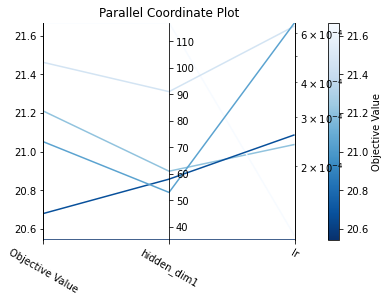

In [33]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=["hidden_dim1", "lr" ])
optuna.visualization.plot_param_importances(study)

In [34]:
#Download the PT file
from google.colab import files
files.download('GRU_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
#Read the pk file
model = GRU(input_size = 9,
             hidden_size1 = 35,
             num_layers=1,
             output_dim=24, 
             seq_len=5*24)

model.load_state_dict(torch.load("GRU_BO.pt"))

<All keys matched successfully>

In [36]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [37]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [38]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x
        batch_y = batch_y
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().numpy())
        true.append(batch_y.detach().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   59.06876508382171
R^2                :        0.9933297195750094
Mean Absolute Error:        46.97548977115118
MAPE               :        0.007909903013612989


error for next 2 hour prediction
Root Mean Squared Error :   94.38320805779396
R^2                :        0.9834416209262526
Mean Absolute Error:        73.98096414214199
MAPE               :        0.012643900099995263


error for next 3 hour prediction
Root Mean Squared Error :   113.16255108386191
R^2                :        0.9760622797167103
Mean Absolute Error:        86.88737396790482
MAPE               :        0.014740990551399016


error for next 24 hour prediction
Root Mean Squared Error :   267.2507267240418
R^2                :        0.8408793118849134
Mean Absolute Error:        214.4916755157767
MAPE               :        0.03633537276586527


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


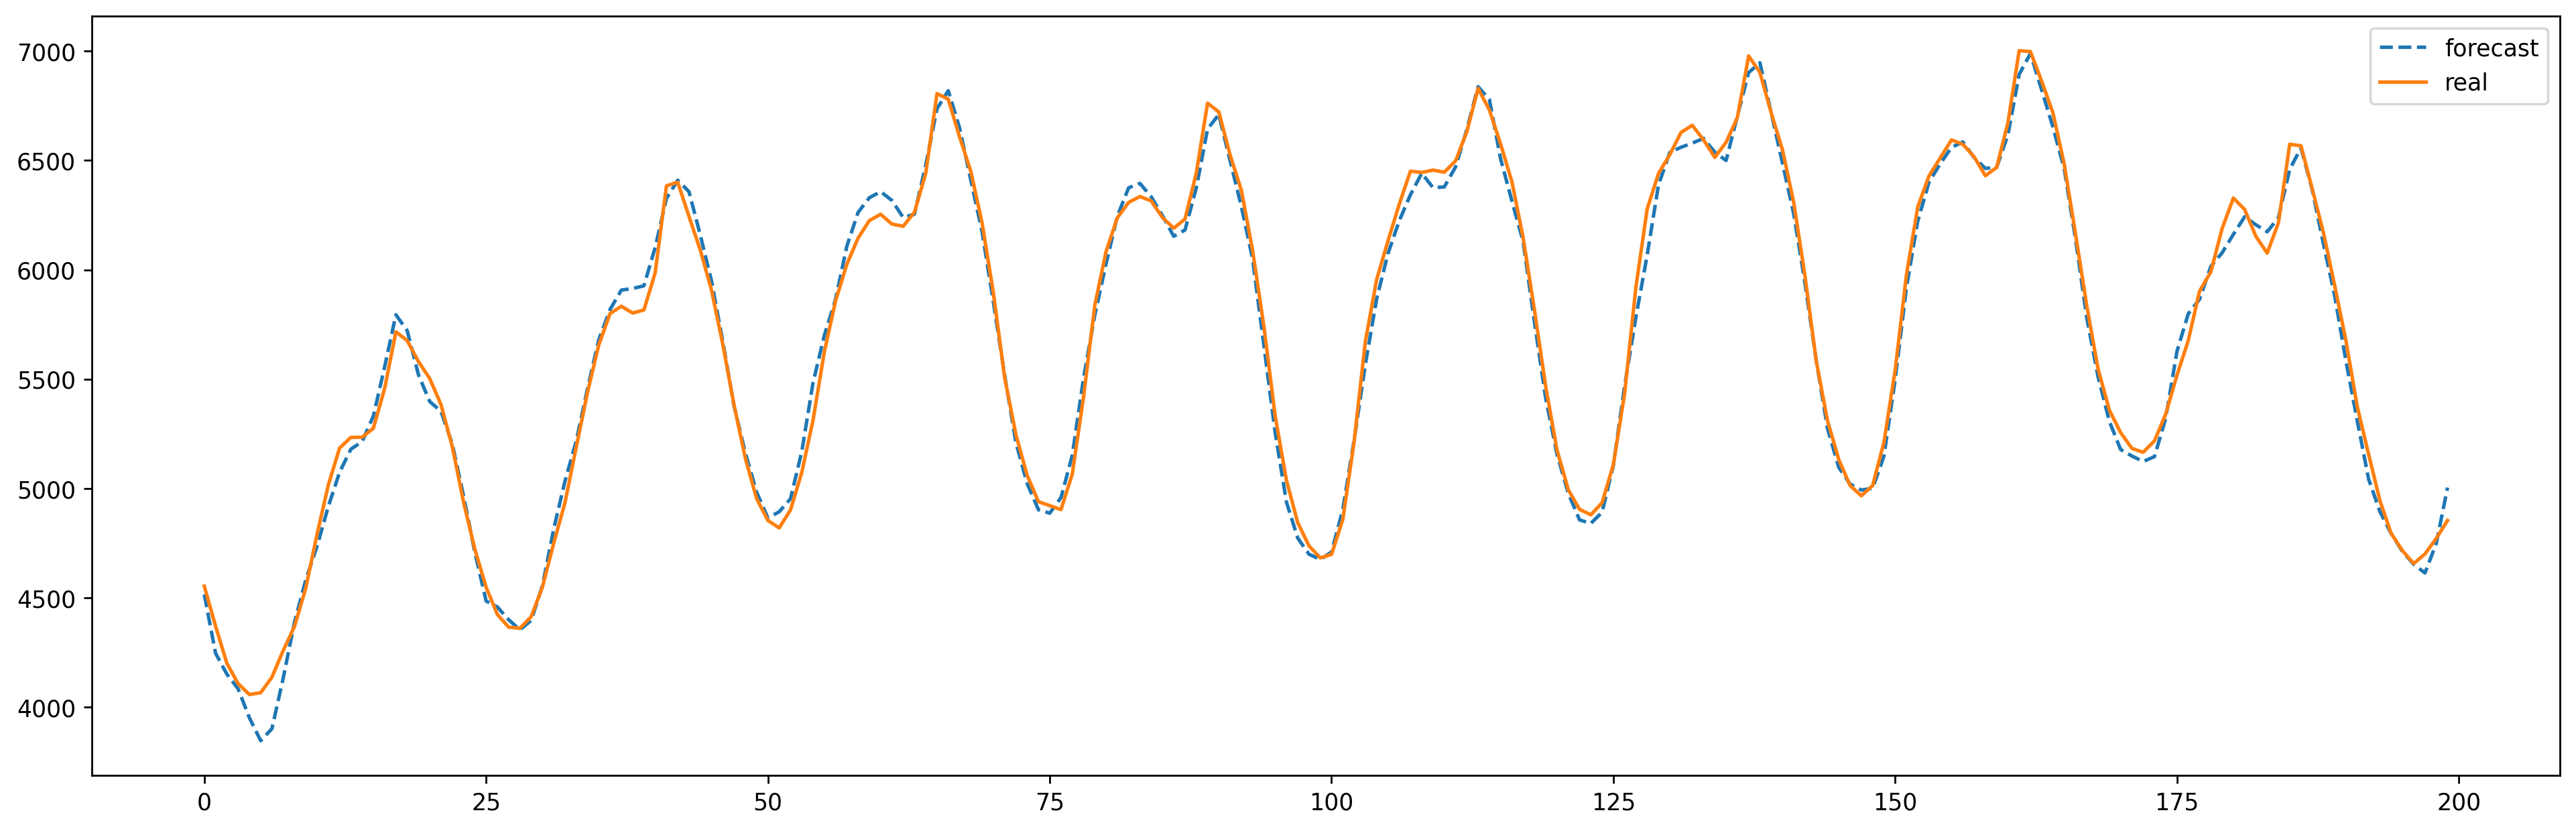

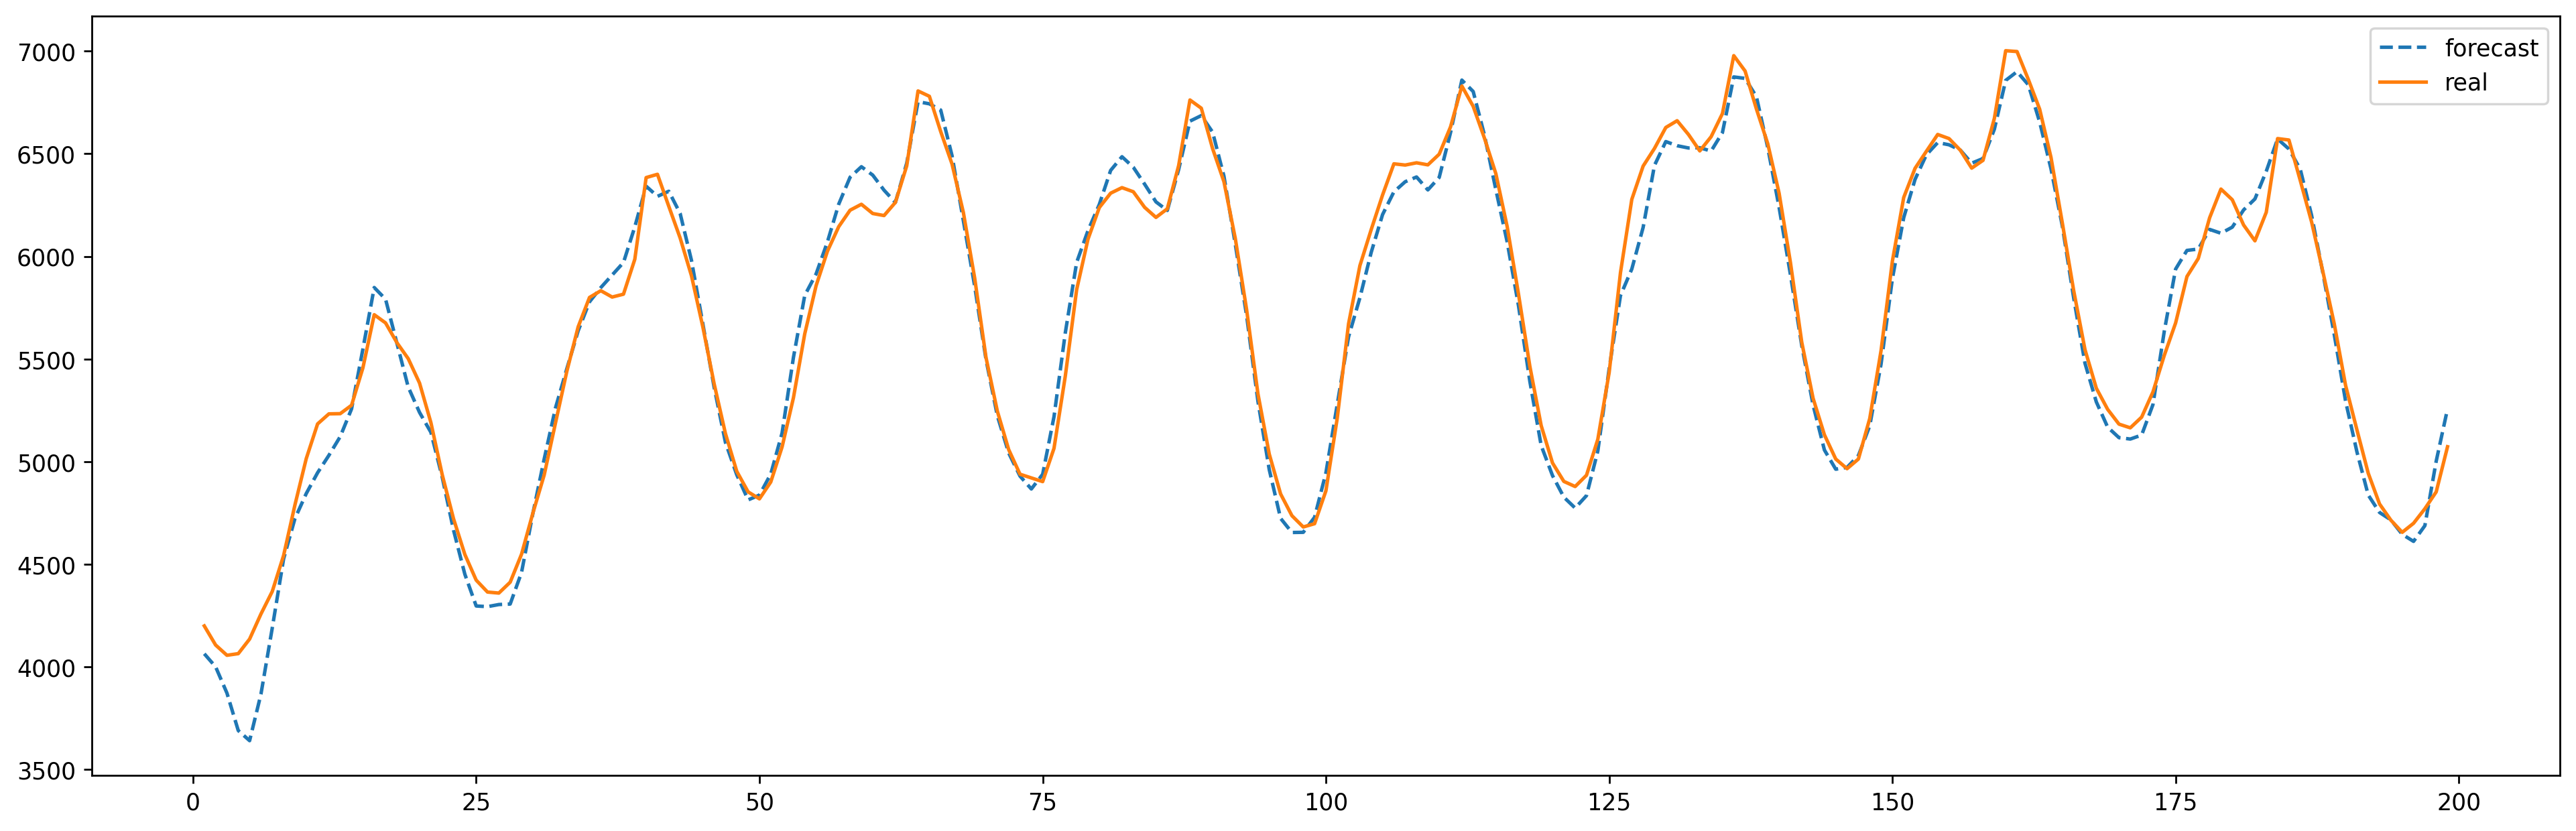

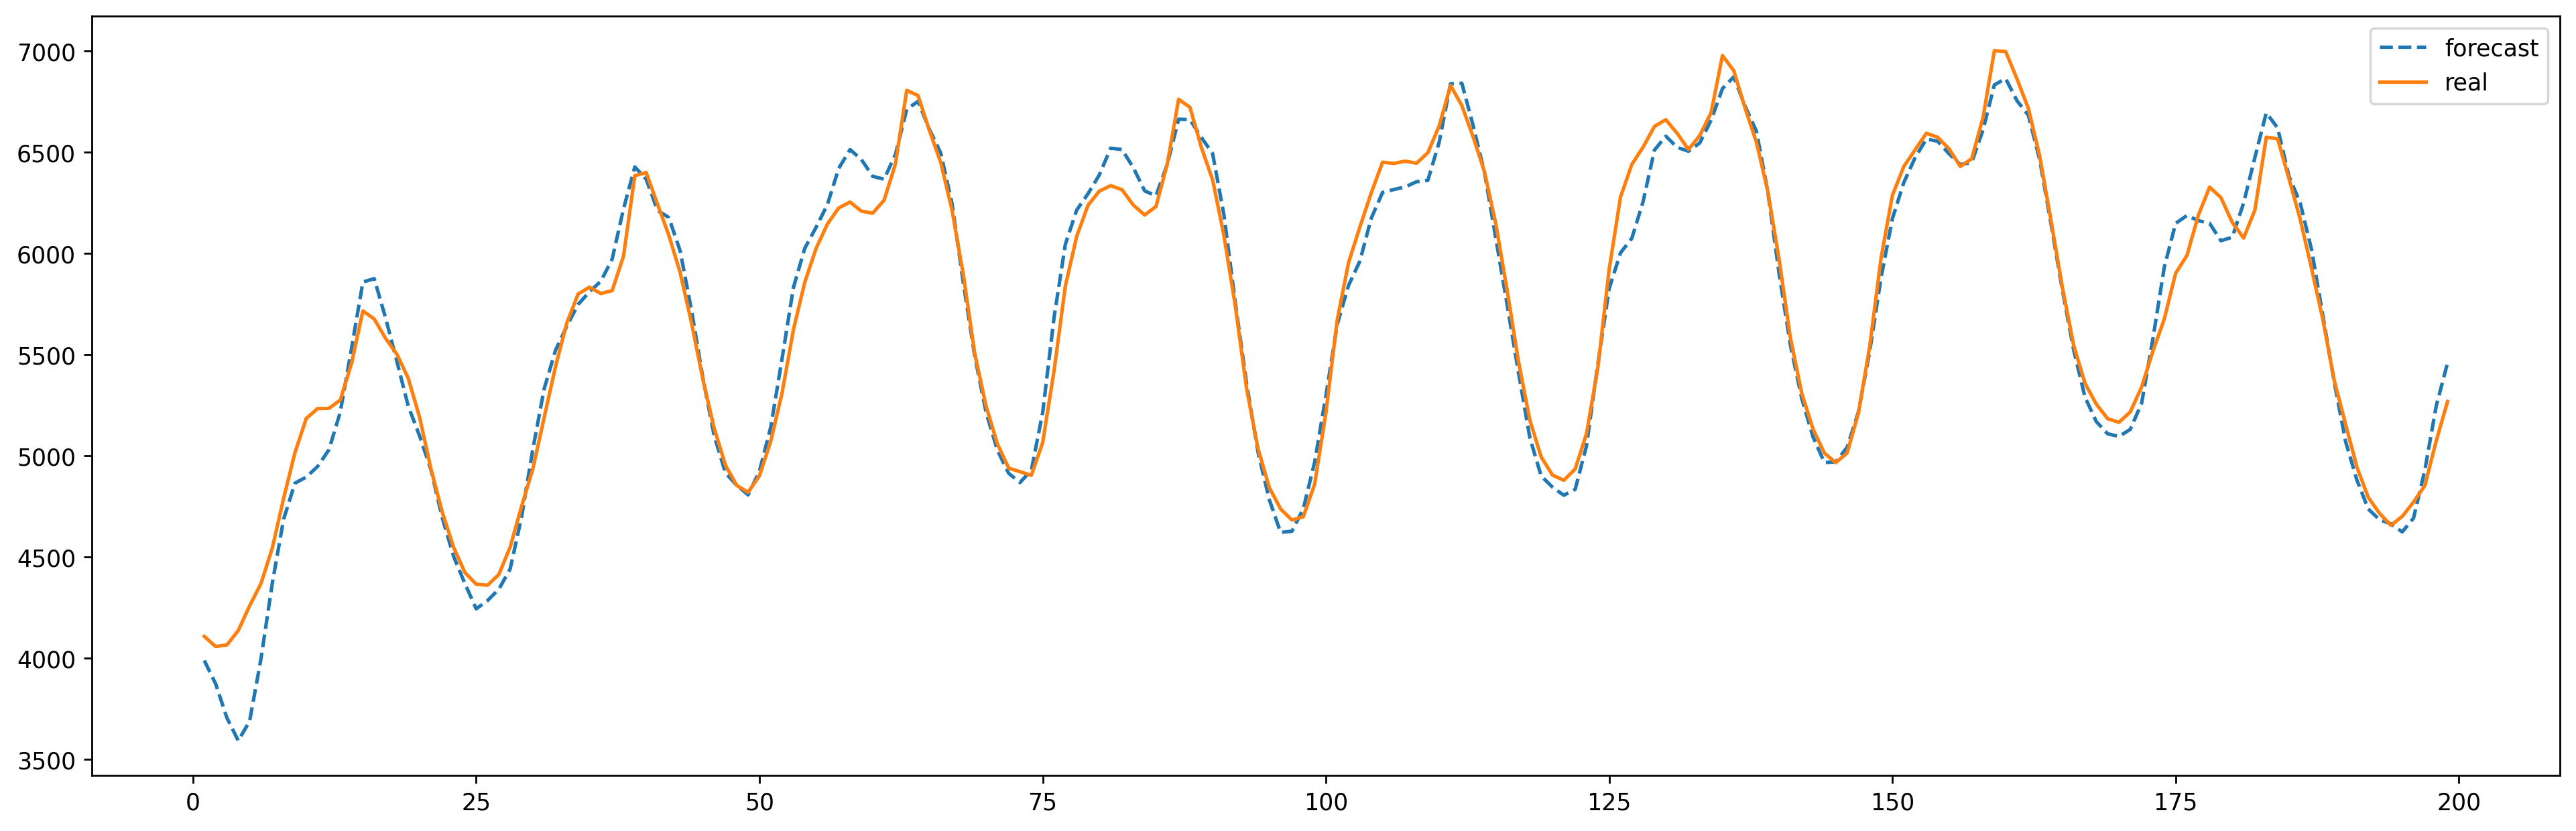

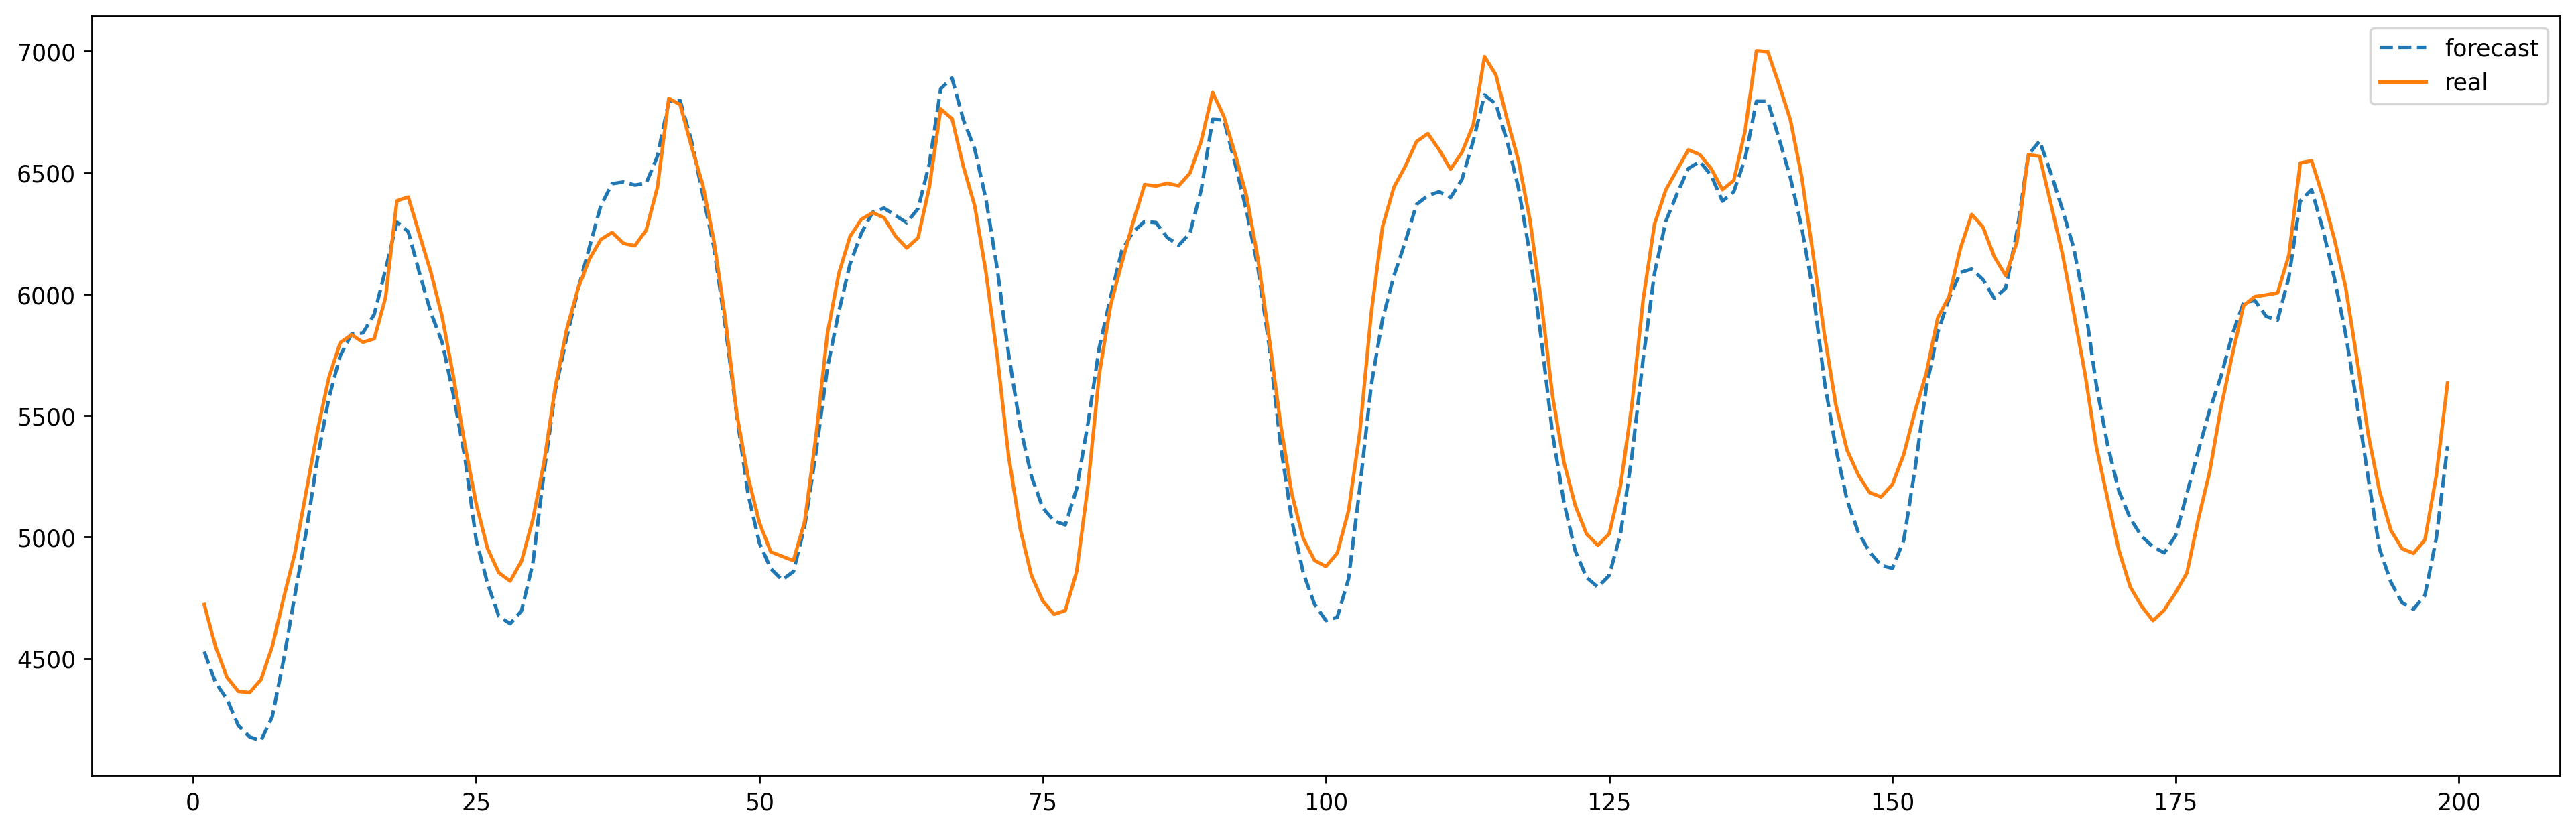

In [40]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [41]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

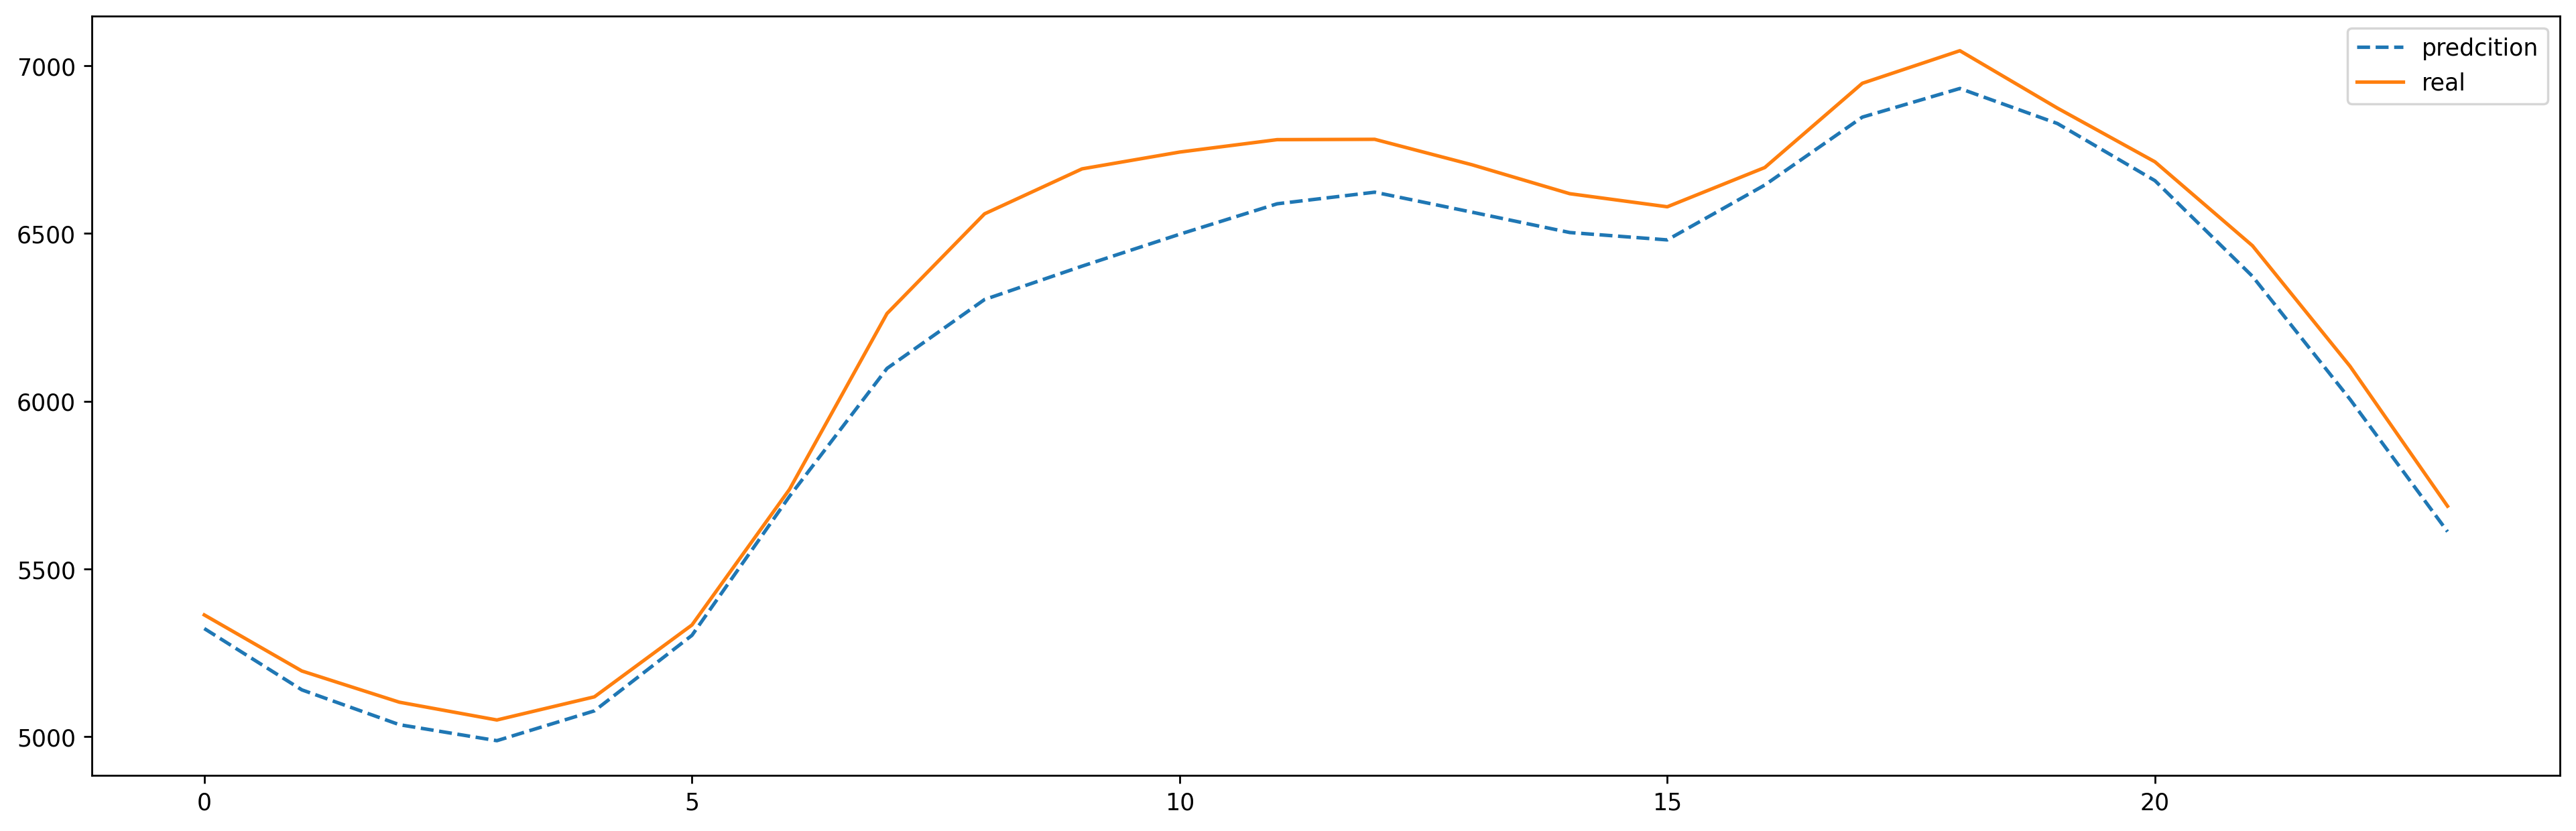

In [45]:
from pandas.tseries.frequencies import Day
figure(figsize=(19, 6), dpi=250)

day=30

dates = range(len(prediction_descaled[day*24]))
plt.plot(dates[0:24], prediction_descaled[day*24] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[day*24], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();